In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
data = pd.read_csv("D:\Python mai programing 2\energy\data\smart_home_energy_consumption_large.csv")
data


,Home ID,Appliance Type,Energy Consumption (kWh),Time,Date,Outdoor Temperature (°C),Season,Household Size
0,94,Fridge,0.20,21:12,2023-12-02,-1.0,Fall,2
1,435,Oven,0.23,20:11,2023-08-06,31.1,Summer,5
2,466,Dishwasher,0.32,06:39,2023-11-21,21.3,Fall,3
3,496,Heater,3.92,21:56,2023-01-21,-4.2,Winter,1
4,137,Microwave,0.44,04:31,2023-08-26,34.5,Summer,5
...,...,...,...,...,...,...,...,...
99995,124,Microwave,0.42,09:56,2023-09-28,20.5,Summer,1
99996,184,Computer,0.71,12:48,2023-05-27,-5.4,Spring,2
99997,101,Dishwasher,0.25,05:45,2023-02-18,35.6,Winter,3
99998,423,Air Conditioning,2.69,12:39,2023-04-20,3.7,Spring,1


In [7]:
data['Appliance Type'].value_counts()


Appliance Type
Lights              10201
Dishwasher          10095
Air Conditioning    10067
Heater              10018
Washing Machine      9953
Microwave            9947
Computer             9944
Oven                 9939
Fridge               9931
TV                   9905
Name: count, dtype: int64

In [10]:

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Home ID                   100000 non-null  int64  
 1   Appliance Type            100000 non-null  object 
 2   Energy Consumption (kWh)  100000 non-null  float64
 3   Time                      100000 non-null  object 
 4   Date                      100000 non-null  object 
 5   Outdoor Temperature (°C)  100000 non-null  float64
 6   Season                    100000 non-null  object 
 7   Household Size            100000 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.1+ MB


In [11]:
data.describe()



,Home ID,Energy Consumption (kWh),Outdoor Temperature (°C),Household Size
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,250.374980,1.499952,14.950135,3.001770
std,144.435367,1.181176,14.438755,1.417077
min,1.000000,0.100000,-10.000000,1.000000
25%,125.000000,0.590000,2.400000,2.000000
50%,250.000000,1.230000,14.900000,3.000000
75%,375.000000,1.870000,27.400000,4.000000
max,500.000000,5.000000,40.000000,5.000000


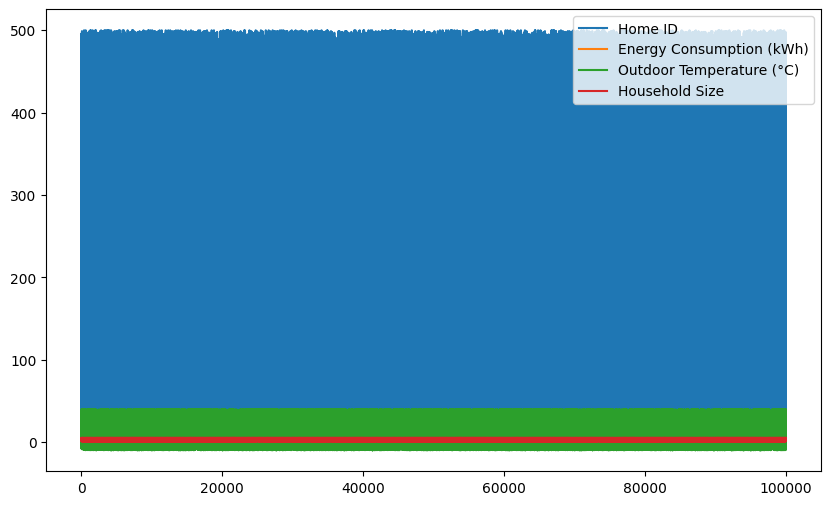

In [14]:
p = data.plot(figsize=(10, 6))


In [26]:
import numpy as np
import pandas as pd
import random

# ---------- helper: time -> 4h slot ----------
def _time_to_slot(t):
    if pd.isna(t) or str(t).strip() == "":
        return None
    try:
        hour = pd.to_datetime(t).hour
    except:
        return None
    return hour // 4   # 0..5


# ---------- helper: generate realistic RTP for one day ----------
def _generate_daily_rtp(seed, min_price=0, max_price=25):
    np.random.seed(seed)
    random.seed(seed)

    slots = np.arange(6)
    base = 10 + 6 * np.sin(2 * np.pi * (slots / 6 - 0.25))
    noise = np.random.normal(0, 1.5, size=6)
    prices = base + noise

    # random peak hours
    for s in random.sample(range(6), random.choice([1, 2])):
        prices[s] += random.uniform(6, 14)

    return np.clip(prices, min_price, max_price).round(2)


# ---------- MAIN FUNCTION ----------
def add_rtp_column(
    data,
    date_col="Date",
    time_col="Time",
    rtp_col="RTP",
    fallback_slot=2,
    global_seed=42
):
    """
    Adds RTP column to dataframe.
    Assumes 4-hour RTP slots (6 per day).
    """

    data = data.copy()
    data["_date"] = pd.to_datetime(data[date_col], errors="coerce").dt.date
    data["_slot"] = data[time_col].apply(_time_to_slot)
    data["_slot"] = data["_slot"].fillna(fallback_slot).astype(int)

    # generate RTP prices per unique date
    rtp_map = {}
    for d in data["_date"].unique():
        seed = global_seed + int(d.strftime("%Y%m%d"))
        rtp_map[d] = _generate_daily_rtp(seed)

    # assign RTP
    data[rtp_col] = data.apply(
        lambda r: rtp_map[r["_date"]][r["_slot"]],
        axis=1
    )

    # cleanup
    data.drop(columns=["_date", "_slot"], inplace=True)

    return data


In [25]:
data = add_rtp_column(data)
data.to_csv("data_with_rtp.csv", index=False)


In [27]:
newdata = pd.read_csv("D:\Python mai programing 2\energy\data_with_rtp.csv")
ELASTICITY_MAP = {
    "Lights": "non-elastic",
    "Air Conditioning": "non-elastic",
    "Heater": "non-elastic",
    "Fridge": "non-elastic",
    "TV": "non-elastic",
    "Computer": "non-elastic",

    "Dishwasher": "elastic",
    "Washing Machine": "elastic",
    "Microwave": "elastic",
    "Oven": "elastic"
}
def add_baseline_cost(newdata, energy_col="Energy Consumption (kWh)", rtp_col="RTP"):
    newdata = newdata.copy()
    newdata["Baseline_Cost"] = newdata[energy_col] * newdata[rtp_col]
    return newdata


In [36]:
newdata = add_baseline_cost(newdata)
newdata.head()


,Home ID,Appliance Type,Energy Consumption (kWh),Time,Date,Outdoor Temperature (°C),Season,Household Size,RTP,Baseline_Cost
0,94,Fridge,0.20,21:12,2023-12-02,-1.0,Fall,2,15.00,3.0000
1,435,Oven,0.23,20:11,2023-08-06,31.1,Summer,5,6.13,1.4099
2,466,Dishwasher,0.32,06:39,2023-11-21,21.3,Fall,3,5.64,1.8048
3,496,Heater,3.92,21:56,2023-01-21,-4.2,Winter,1,8.49,33.2808
4,137,Microwave,0.44,04:31,2023-08-26,34.5,Summer,5,7.03,3.0932


In [37]:
def cheapest_slot_per_day(newdata, date_col="Date", rtp_col="RTP", slot_col="Slot"):
    """
    Assumes Slot column exists (0–5)
    Returns dict: {date -> cheapest_slot}
    """
    cheapest = {}
    for d, g in newdata.groupby(date_col):
        slot_prices = g.groupby(slot_col)[rtp_col].mean()
        cheapest[d] = slot_prices.idxmin()
    return cheapest


In [38]:
def schedule_elastic_appliances(
    newdata,
    elasticity_map,
    date_col="Date",
    slot_col="Slot",
    rtp_col="RTP",
    energy_col="Energy Consumption (kWh)"
):
    newdata = newdata.copy()

    cheapest_slot = cheapest_slot_per_day(newdata, date_col, rtp_col, slot_col)

    newdata["Scheduled_Slot"] = newdata.apply(
        lambda r: (
            cheapest_slot[r[date_col]]
            if elasticity_map.get(r["Appliance Type"], "elastic") == "elastic"
            else r[slot_col]
        ),
        axis=1
    )

    # Map slot → RTP again
    slot_rtp_map = (
        newdata.groupby([date_col, slot_col])[rtp_col]
        .mean()
        .to_dict()
    )

    newdata["Scheduled_RTP"] = newdata.apply(
        lambda r: slot_rtp_map[(r[date_col], r["Scheduled_Slot"])],
        axis=1
    )

    newdata["Optimized_Cost"] = newdata[energy_col] * newdata["Scheduled_RTP"]

    return newdata
def schedule_elastic_appliances(
    newdata,
    elasticity_map,
    date_col="Date",
    slot_col="Slot",
    rtp_col="RTP",
    energy_col="Energy Consumption (kWh)"
):
    newdata = newdata.copy()

    cheapest_slot = cheapest_slot_per_day(newdata, date_col, rtp_col, slot_col)

    newdata["Scheduled_Slot"] = newdata.apply(
        lambda r: (
            cheapest_slot[r[date_col]]
            if elasticity_map.get(r["Appliance Type"], "elastic") == "elastic"
            else r[slot_col]
        ),
        axis=1
    )

    # Map slot → RTP again
    slot_rtp_map = (
        newdata.groupby([date_col, slot_col])[rtp_col]
        .mean()
        .to_dict()
    )

    newdata["Scheduled_RTP"] = newdata.apply(
        lambda r: slot_rtp_map[(r[date_col], r["Scheduled_Slot"])],
        axis=1
    )

    newdata["Optimized_Cost"] = newdata[energy_col] * newdata["Scheduled_RTP"]

    return newdata


In [40]:
# Copy and paste this into the cell where you call schedule_elastic_appliances (Cell 39)

def _time_to_slot_safe(t):
    """Helper to convert time string to 4-hour slot index (0-5)."""
    try:
        return pd.to_datetime(t).hour // 4
    except:
        return 2  # Fallback

# The 'Slot' column was dropped earlier, so we need to recreate it
if 'Slot' not in newdata.columns:
    print("Re-creating missing 'Slot' column...")
    newdata['Slot'] = newdata['Time'].apply(_time_to_slot_safe)

# Now calling the function should work
try:
    newdata = schedule_elastic_appliances(newdata, ELASTICITY_MAP)
    print("Success: Appliances scheduled!")
except Exception as e:
    print(f"Error: {e}")


Re-creating missing 'Slot' column...
Success: Appliances scheduled!


In [42]:
newdata = schedule_elastic_appliances(newdata, ELASTICITY_MAP)


In [45]:
def cost_summary(newdata):
    return {
        "Baseline_Cost": newdata["Baseline_Cost"].sum(),
        "Optimized_Cost": newdata["Optimized_Cost"].sum(),
        "Savings": newdata["Baseline_Cost"].sum() - newdata["Optimized_Cost"].sum(),
        "Savings_%": (
            (newdata["Baseline_Cost"].sum() - newdata["Optimized_Cost"].sum())
            / newdata["Baseline_Cost"].sum()
        ) * 100
    }


In [46]:
summary = cost_summary(newdata)
print(summary)


{'Baseline_Cost': np.float64(1831545.3223), 'Optimized_Cost': np.float64(1488756.1535), 'Savings': np.float64(342789.1688000001), 'Savings_%': np.float64(18.71584419049678)}
